In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

!unzip -q '/content/drive/MyDrive/mp_dataset/new-plant-diseases-dataset.zip' -d '/content'
# drive.flush_and_unmount()


Mounted at /content/drive


In [2]:
data_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = '/content/drive/MyDrive/mp_dataset/datastore/test'

In [15]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [9]:
# Creating datasets from folder name as labels

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_set = train_datagen.flow_from_directory(train_dir,
                                              target_size=(224, 224),
                                              batch_size=batch_size,
                                              class_mode='categorical')

valid_set = valid_datagen.flow_from_directory(valid_dir,
                                              target_size=(224, 224),
                                              batch_size=batch_size,
                                              class_mode='categorical')

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [10]:
base_model = keras.applications.VGG16(
    weights="imagenet",  # load weights pretrained on the ImageNet
    input_shape=(224, 224, 3),
    include_top=False  # do not include the ImageNet classifier at the top
)  

In [11]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(38)(x)

vgg16_model = keras.Model(inputs, outputs, name='pretrained_vgg16')
vgg16_model.summary()

Model: "pretrained_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 38)                19494     
                                                                 
Total params: 14,734,182
Trainable params: 19,494
Non-trainable params: 14,714,688
_________________________________

In [13]:
vgg16_model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()]
)

epochs = 30

vgg16_history = vgg16_model.fit(train_set,
                                steps_per_epoch=100,  
                                validation_data=valid_set,
                                epochs=epochs,
                                validation_steps=60,  
)

Epoch 1/30
100/100 [==============================] - 73s 685ms/step - loss: 3.5786 - categorical_accuracy: 0.0825 - val_loss: 3.2914 - val_categorical_accuracy: 0.2245
Epoch 2/30
100/100 [==============================] - 68s 675ms/step - loss: 3.2246 - categorical_accuracy: 0.2181 - val_loss: 2.9909 - val_categorical_accuracy: 0.4000
Epoch 3/30
100/100 [==============================] - 67s 668ms/step - loss: 2.9660 - categorical_accuracy: 0.3125 - val_loss: 2.7121 - val_categorical_accuracy: 0.5104
Epoch 4/30
100/100 [==============================] - 67s 669ms/step - loss: 2.7175 - categorical_accuracy: 0.4087 - val_loss: 2.5144 - val_categorical_accuracy: 0.5271
Epoch 5/30
100/100 [==============================] - 67s 666ms/step - loss: 2.5425 - categorical_accuracy: 0.4678 - val_loss: 2.2972 - val_categorical_accuracy: 0.5995
Epoch 6/30
100/100 [==============================] - 66s 662ms/step - loss: 2.3642 - categorical_accuracy: 0.5153 - val_loss: 2.1584 - val_categorical_acc

In [14]:
# Evaluate the model on the validation data

results = vgg16_model.evaluate(valid_set)
print('val loss:', results[0])
print('val acc:', results[1])

550/550 [==============================] - 162s 294ms/step - loss: 0.9898 - categorical_accuracy: 0.7795
val loss: 0.9898070096969604
val acc: 0.7794787287712097


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set parameters for plotting
plt.rc('figure', figsize=(8, 4))
sns.set(font_scale=1)

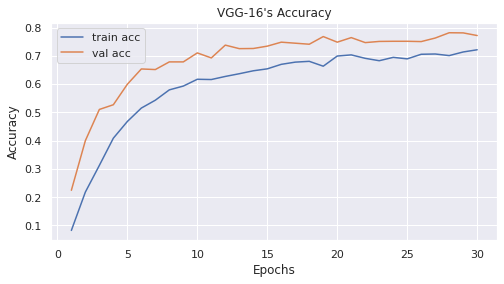

In [17]:
train_acc = vgg16_history.history['categorical_accuracy']
val_acc = vgg16_history.history['val_categorical_accuracy']

epochs_list = list(range(1, epochs + 1))

plt.plot(epochs_list, train_acc, label='train acc')
plt.plot(epochs_list, val_acc, label='val acc')
plt.title("VGG-16's Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

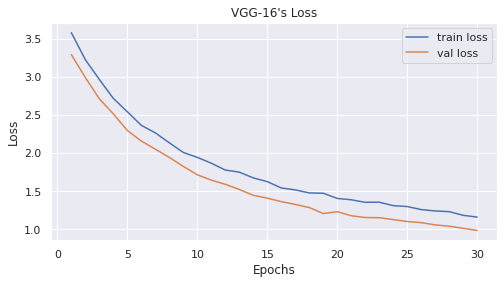

In [18]:
train_loss = vgg16_history.history['loss']
val_loss = vgg16_history.history['val_loss']

plt.plot(epochs_list, train_loss, label='train loss')
plt.plot(epochs_list, val_loss, label='val loss')
plt.title("VGG-16's Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

In [19]:
vgg16_model.save('vgg16')

INFO:tensorflow:Assets written to: vgg16/assets


In [21]:
# !zip -r /content/vgg16.zip /content/vgg16
from google.colab import files
files.download("/content/vgg16.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>